In [2]:
import os
print(os.getcwd())

C:\Users\nehak


In [5]:
import numpy as np

import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from IPython.display import display as ipython_display, Image as IPythonImage
from PIL import Image
import os
import time
import io

In [2]:
# Disable the interactive matplotlib backend for inline display
%matplotlib inline

In [14]:
# --- Step 1: Imports and Seed Fixing ---
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)


In [8]:
# --- Step 2: Define Maze Environment ---
class MazeEnv(gym.Env):
    """
    Custom Maze/Grid environment for RL
    State: agent's (row, col)
    Actions: 0=up, 1=down, 2=left, 3=right
    Reward shaping: -0.01 per step, -0.5 for invalid move, +1 for goal
    """
    metadata = {"render_modes": ["rgb_array"], "render_fps": 4}

    def __init__(self, maze_array, start_cell, exit_cell):
        super(MazeEnv, self).__init__()
        self.maze = np.array(maze_array)
        self.n_rows, self.n_cols = self.maze.shape
        self.start_cell = start_cell
        self.exit_cell = exit_cell
        self.agent_pos = self.start_cell
        self.path = []
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=max(self.n_rows, self.n_cols) - 1, shape=(2,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_pos = self.start_cell
        self.path = [self.start_cell]
        return np.array(self.agent_pos, dtype=np.float32), {}

    def step(self, action):
        row, col = self.agent_pos
        reward = -0.01
        invalid_move = False

        if action == 0 and row > 0 and self.maze[row - 1, col] == 0:
            row -= 1
        elif action == 1 and row < self.n_rows - 1 and self.maze[row + 1, col] == 0:
            row += 1
        elif action == 2 and col > 0 and self.maze[row, col - 1] == 0:
            col -= 1
        elif action == 3 and col < self.n_cols - 1 and self.maze[row, col + 1] == 0:
            col += 1
        else:
            invalid_move = True
            reward -= 0.5

        self.agent_pos = (row, col)
        self.path.append(self.agent_pos)
        terminated = self.agent_pos == self.exit_cell
        if terminated:
            reward += 1.0

        return np.array(self.agent_pos, dtype=np.float32), reward, terminated, False, {'invalid_move': invalid_move}

    def render(self):
        display_maze = self.maze.copy()
        fig, ax = plt.subplots(figsize=(4, 4)) # Reduced figure size for inline display
        
        ax.imshow(display_maze, cmap=plt.cm.binary)
        ax.set_xticks(np.arange(self.n_cols + 1) - .5, minor=True)
        ax.set_yticks(np.arange(self.n_rows + 1) - .5, minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
        ax.tick_params(which="minor", bottom=False, left=False)
        plt.gca().set_aspect('equal', adjustable='box')

        if len(self.path) > 1:
            path_array = np.array(self.path)
            ax.plot(path_array[:, 1], path_array[:, 0], 'o-', color='blue')

        ax.text(self.start_cell[1], self.start_cell[0], 'Start', color='red', ha='center', va='center', fontsize=8, fontweight='bold')
        ax.text(self.exit_cell[1], self.exit_cell[0], 'Exit', color='green', ha='center', va='center', fontsize=8, fontweight='bold')

        ax.plot(self.agent_pos[1], self.agent_pos[0], 'o', color='red', markersize=8)
        
        plt.title('Maze Agent Traversal')
        plt.tight_layout()
        
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        plt.close(fig)
        return IPythonImage(data=buf.read(), width=250)

    def render_final(self, filename):
        display_maze = self.maze.copy()
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.imshow(display_maze, cmap=plt.cm.binary)
        ax.set_xticks(np.arange(self.n_cols + 1) - .5, minor=True)
        ax.set_yticks(np.arange(self.n_rows + 1) - .5, minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
        ax.tick_params(which="minor", bottom=False, left=False)

        path_array = np.array(self.path)
        ax.plot(path_array[:, 1], path_array[:, 0], 'o-', color='blue', linewidth=3, markersize=8)

        ax.text(self.start_cell[1], self.start_cell[0], 'Start', color='red', ha='center', va='center', fontsize=12, fontweight='bold')
        ax.text(self.exit_cell[1], self.exit_cell[0], 'Exit', color='green', ha='center', va='center', fontsize=12, fontweight='bold')
        
        plt.title(f'Final Path - {os.path.basename(filename).split(".")[0]}')
        plt.tight_layout()
        plt.savefig(filename)
        plt.show()

In [10]:
# --- Step 3: Maze Layout and Environment Initialization ---
maze_layout = [
    [0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 1, 0, 1, 0],
    [0, 0, 0, 1, 0, 1, 0, 1, 0],
    [1, 0, 1, 1, 0, 0, 0, 1, 0],
    [0, 0, 1, 1, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 1, 0],
    [0, 1, 0, 1, 1, 1, 0, 1, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 1, 0, 0, 0]
]

start_cell = (0, 2)
exit_cell = (8, 7)

env = MazeEnv(maze_layout, start_cell, exit_cell)
check_env(env)

In [11]:
# --- Step 4: Gameplay Visualization Function ---
def visualize_gameplay(model, env, title, max_steps=100):
    print(f"\n--- Visualizing {title} ---")
    
    obs, _ = env.reset()
    done = False
    step_count = 0

    while not done and step_count < max_steps:
        ipython_display(env.render())
        step_count += 1
        
        if model.__class__.__name__ == 'PPO' or model.__class__.__name__ == 'SAC':
            action, _ = model.predict(obs, deterministic=True)
        elif model.__class__.__name__ == 'QLearningAgent':
            r, c = obs.astype(int)
            action = np.argmax(model.q_table[r, c])
        else: # Random baseline
            action = env.action_space.sample()

        obs, reward, terminated, _, _ = env.step(action)
        done = terminated
        
    ipython_display(env.render())
    print(f"{title} gameplay finished in {step_count} steps.")


--- Visualizing Random Baseline ---


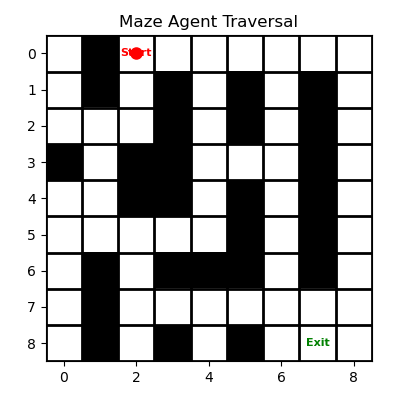

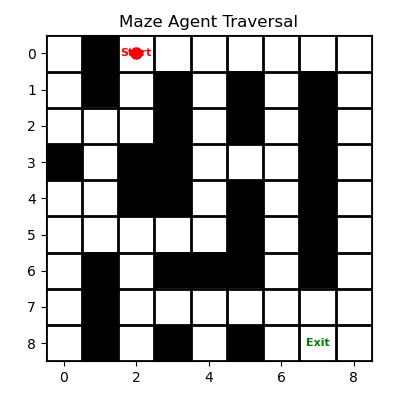

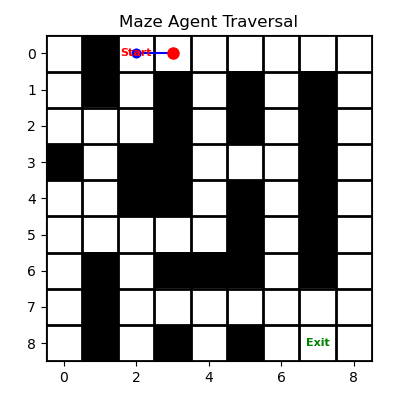

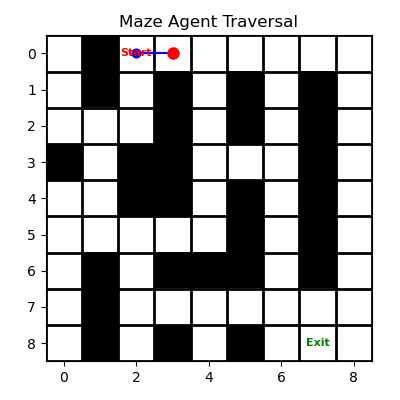

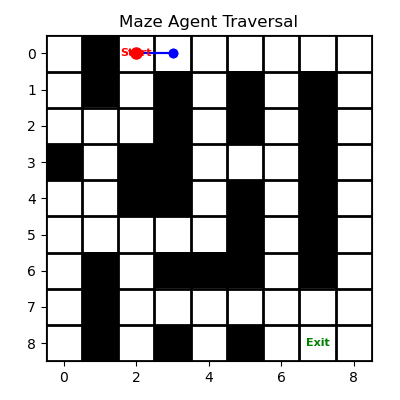

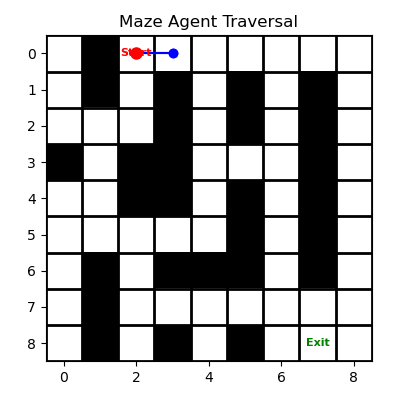

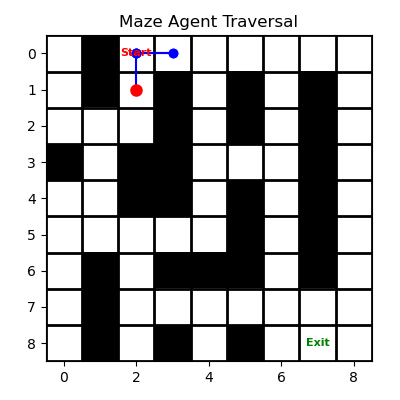

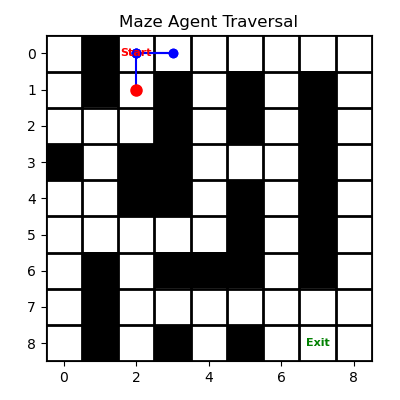

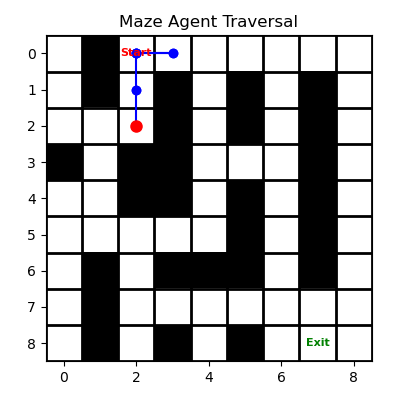

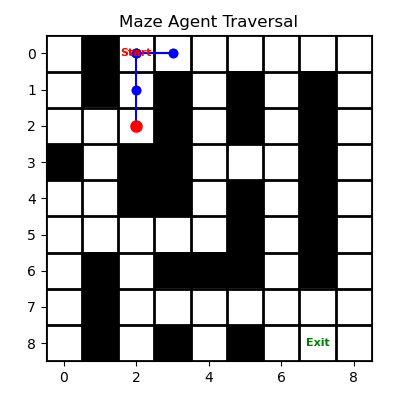

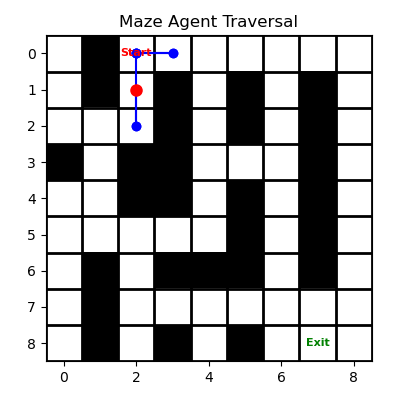

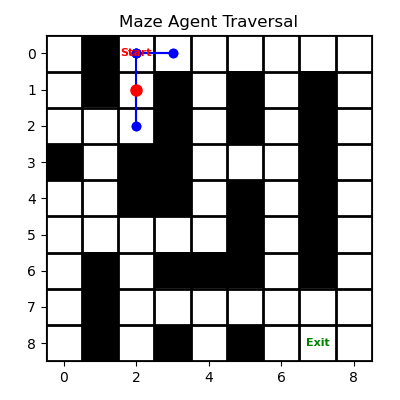

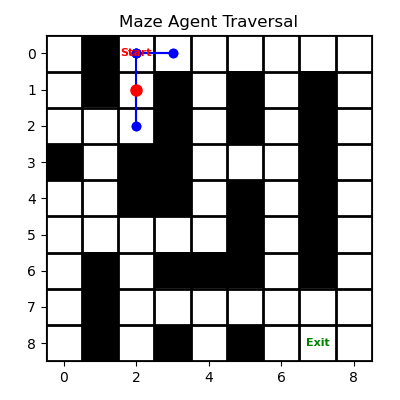

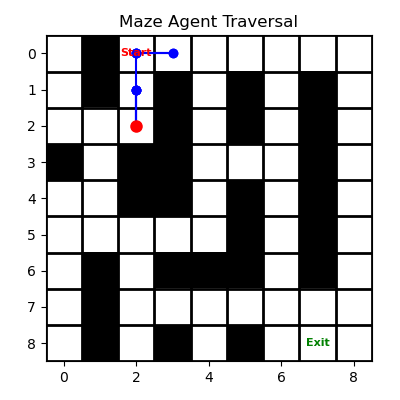

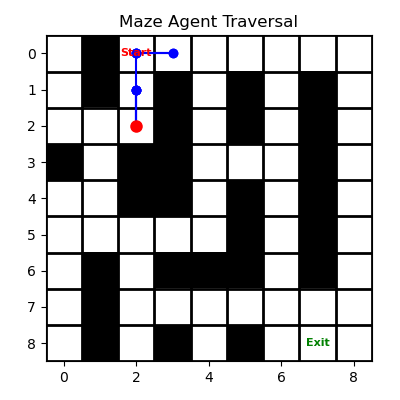

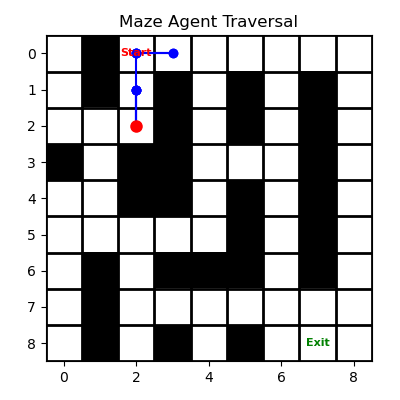

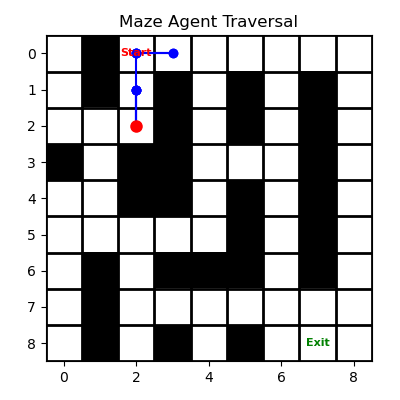

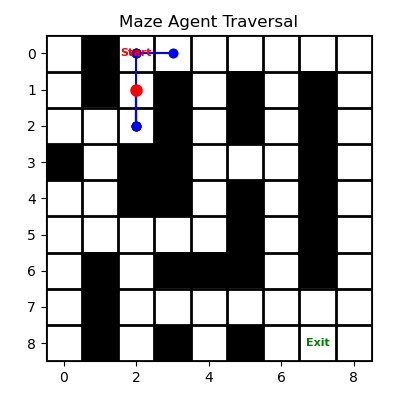

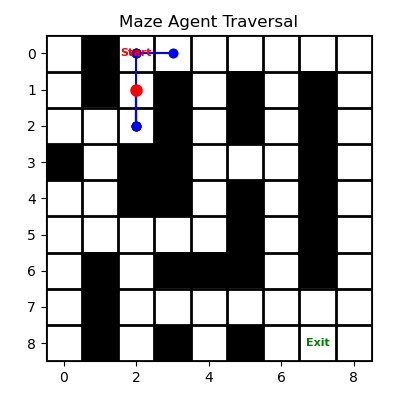

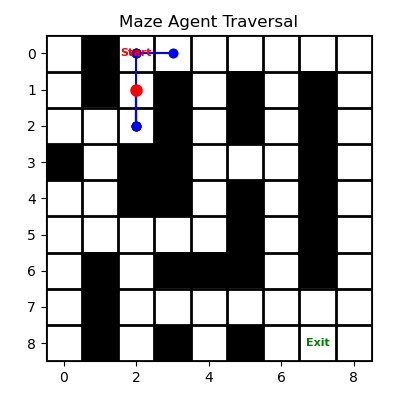

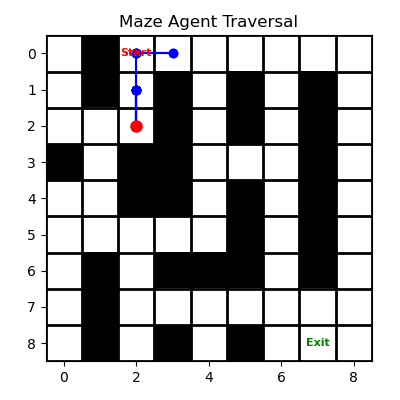

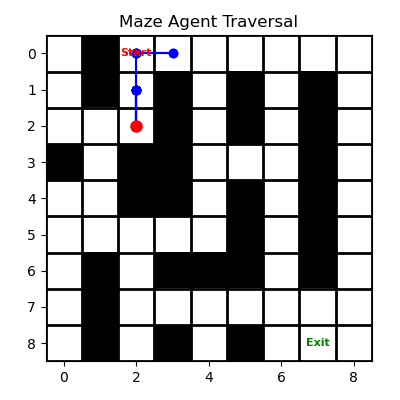

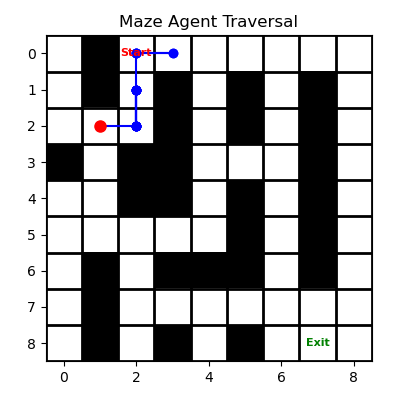

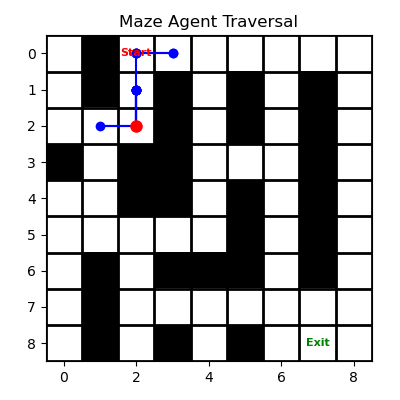

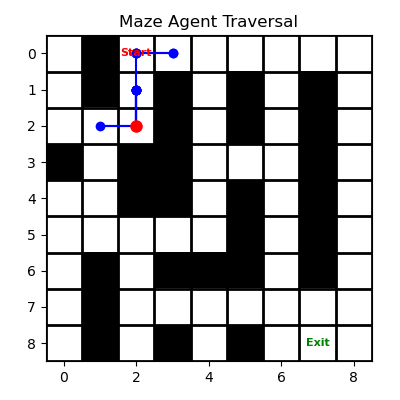

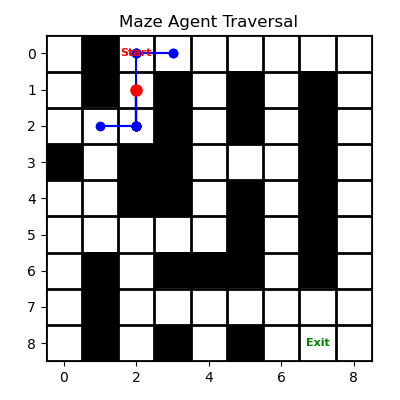

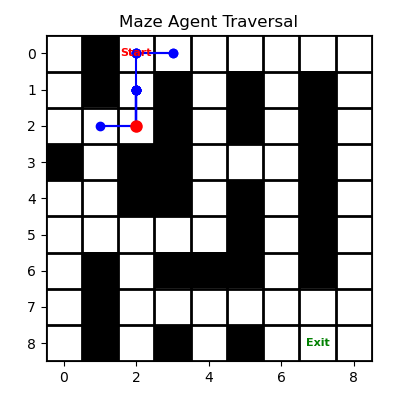

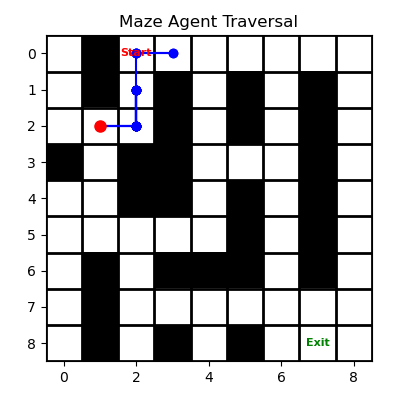

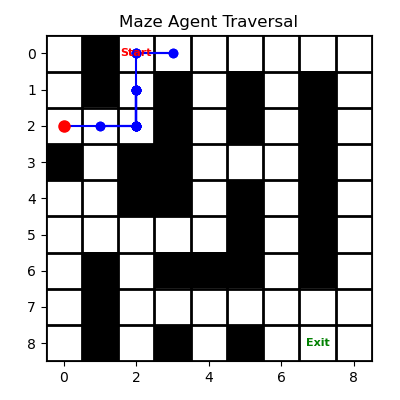

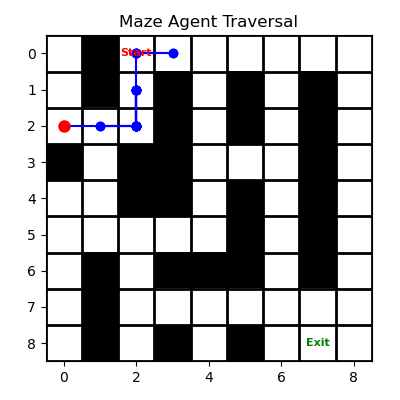

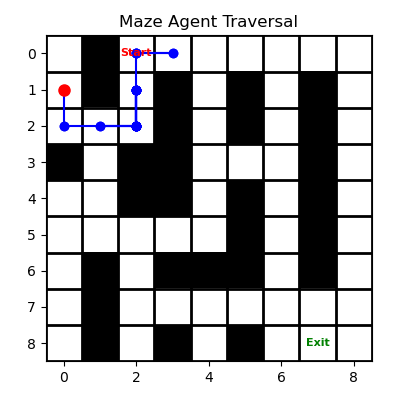

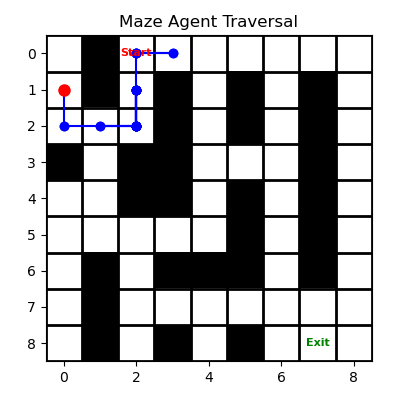

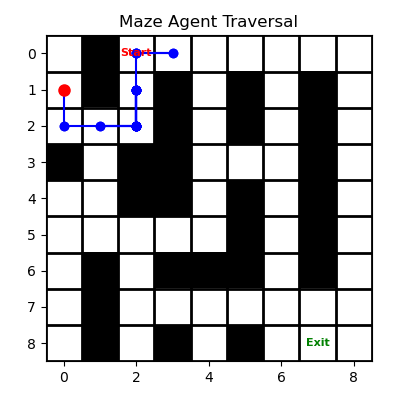

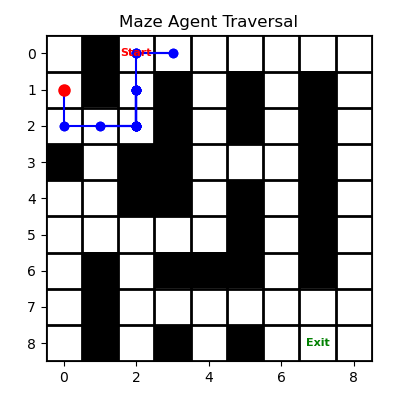

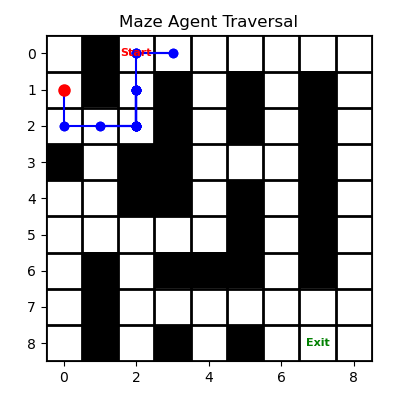

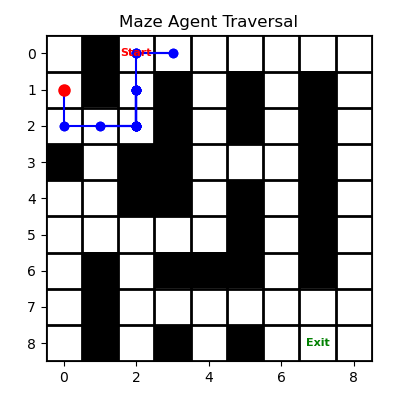

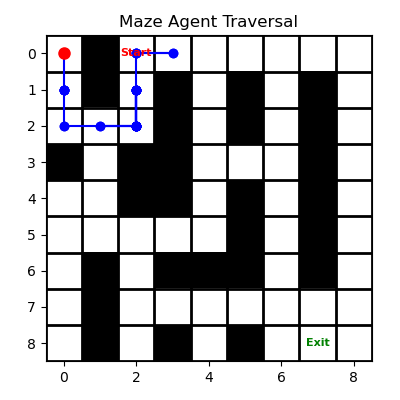

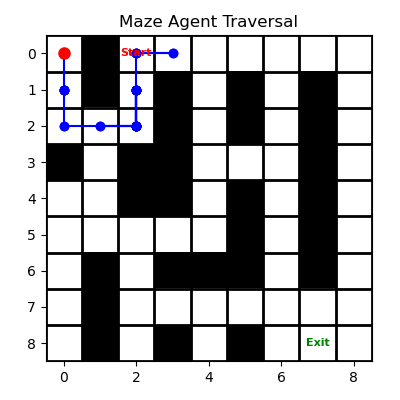

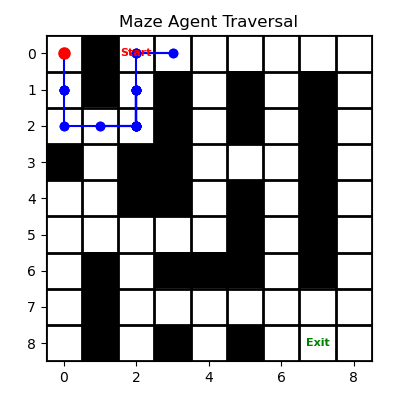

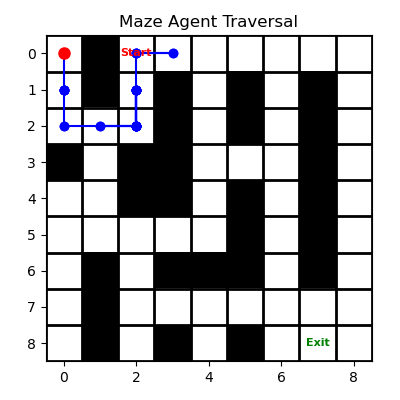

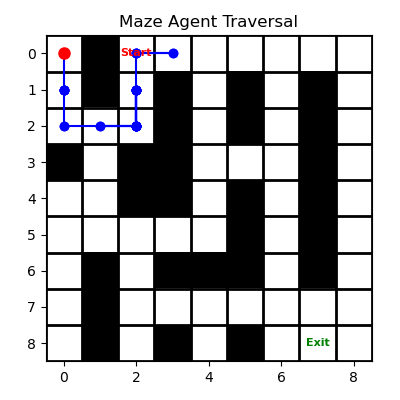

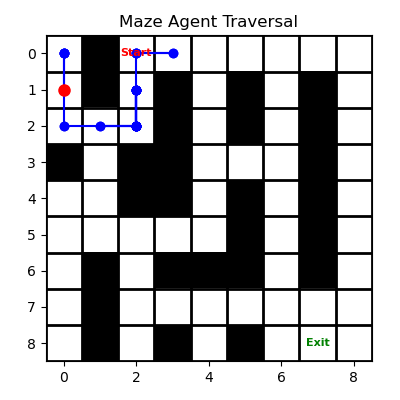

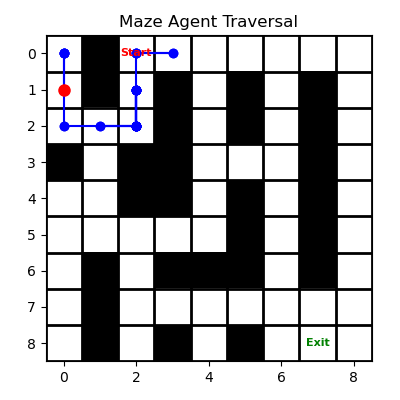

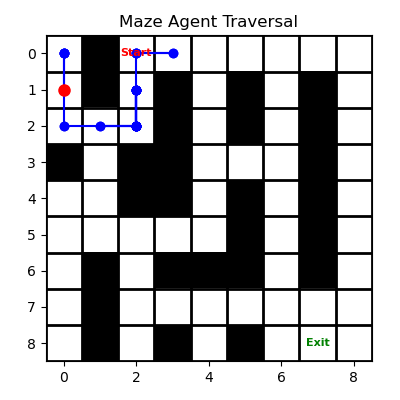

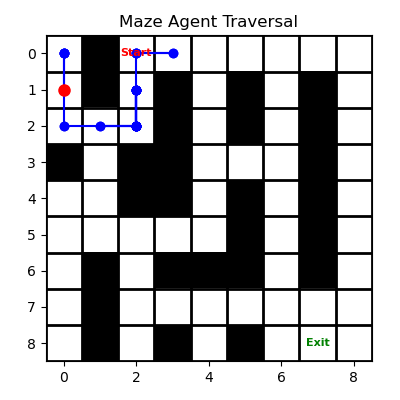

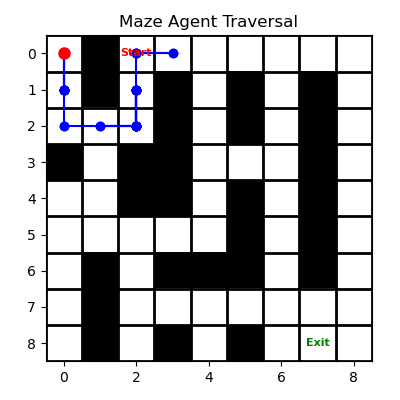

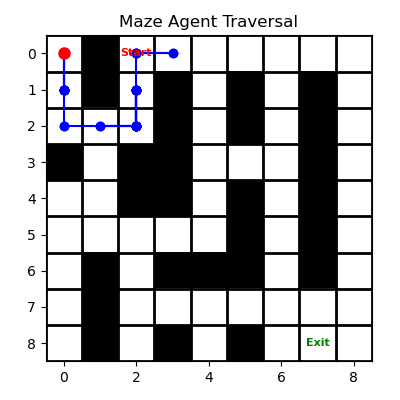

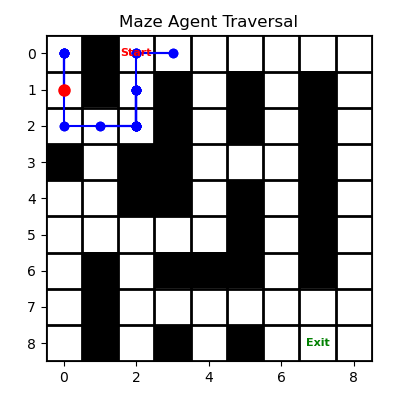

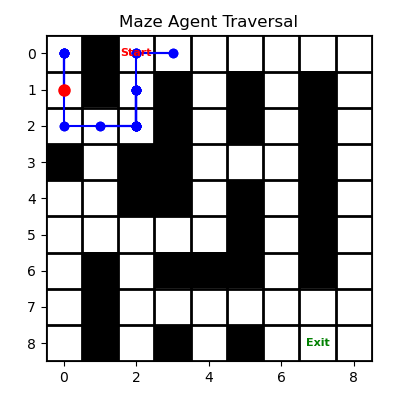

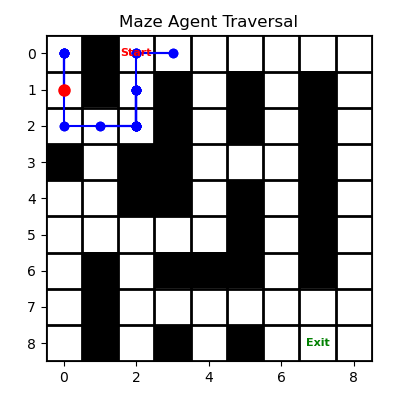

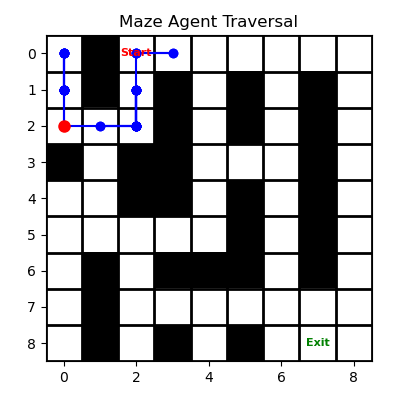

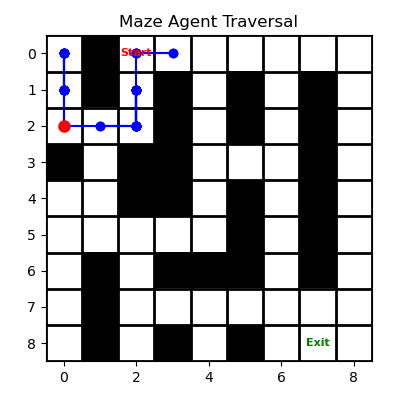

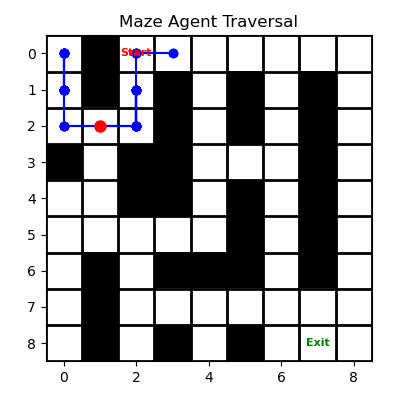

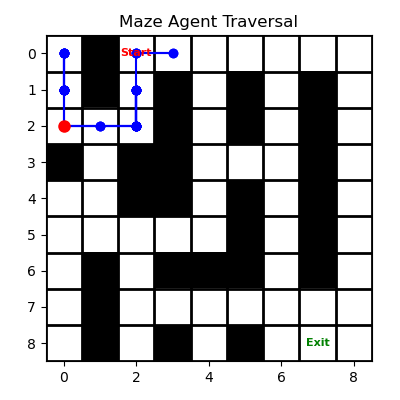

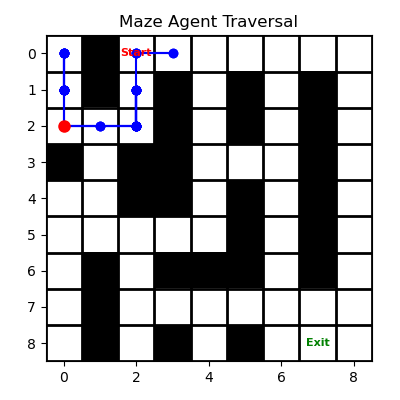

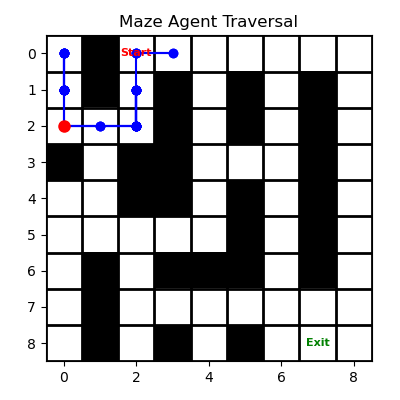

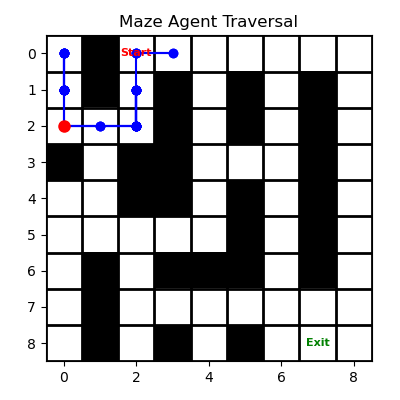

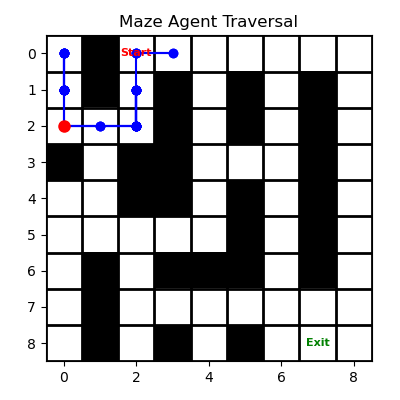

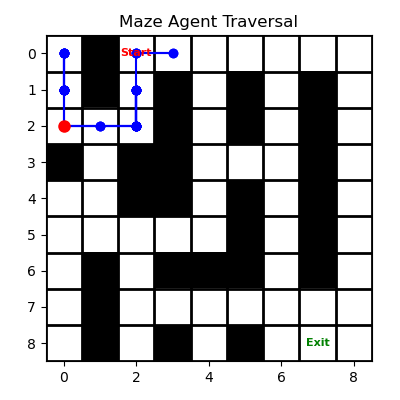

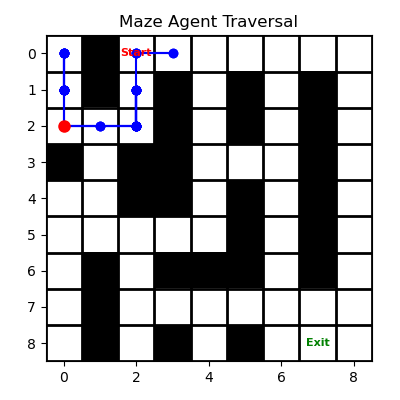

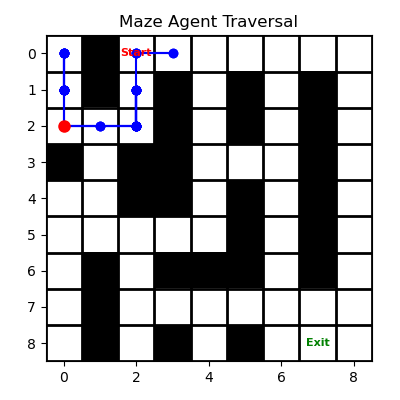

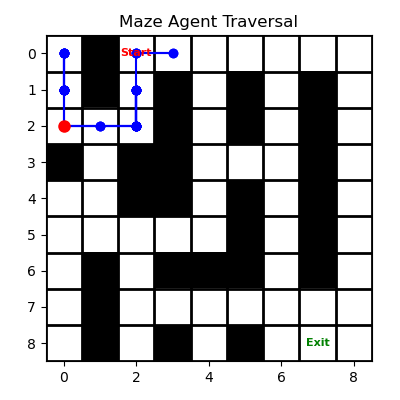

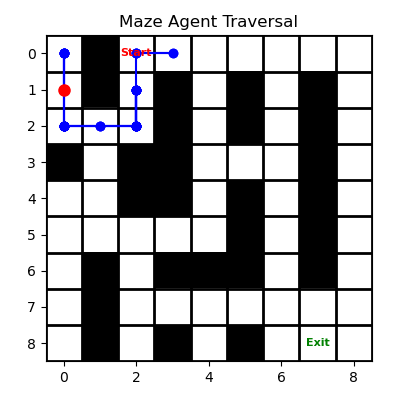

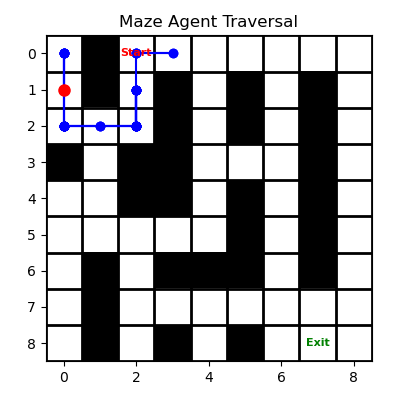

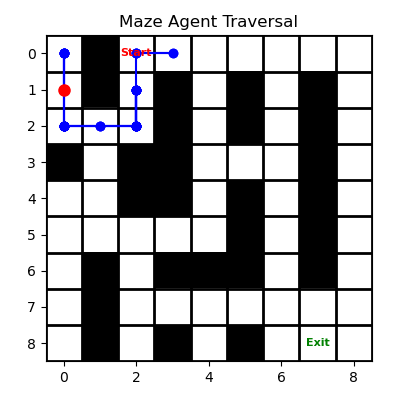

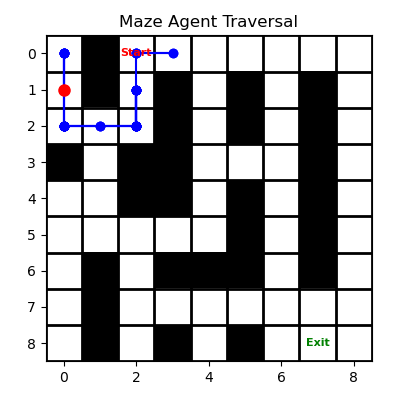

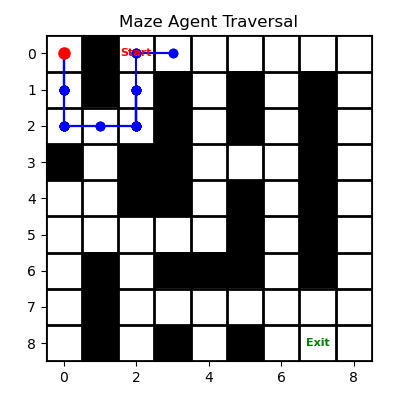

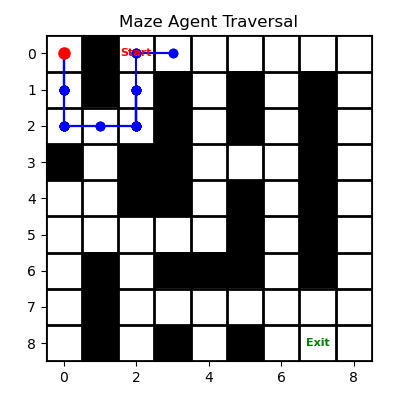

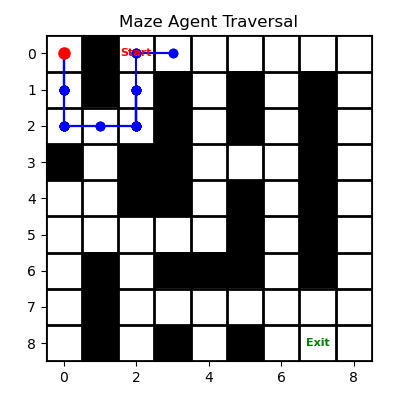

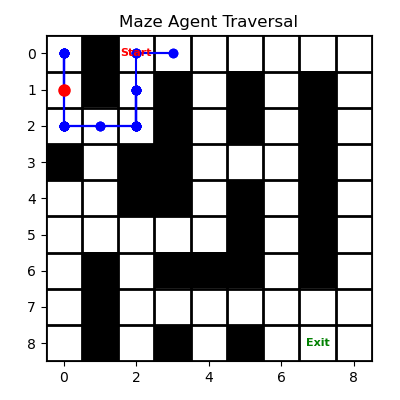

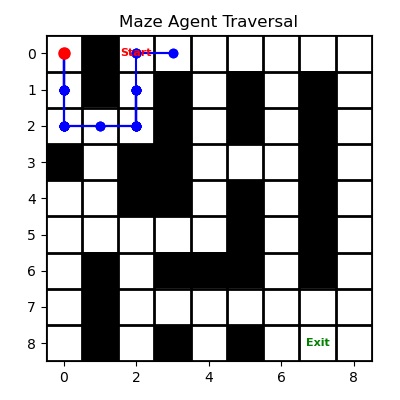

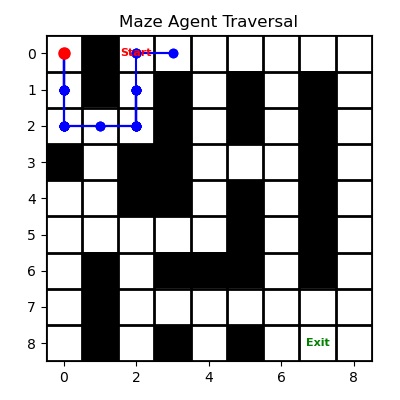

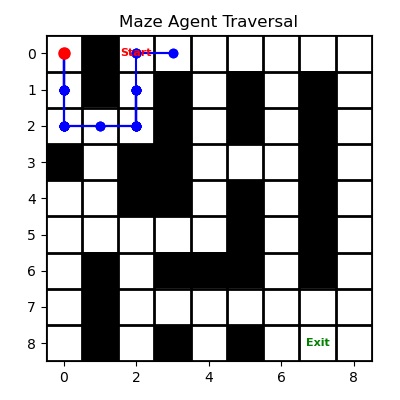

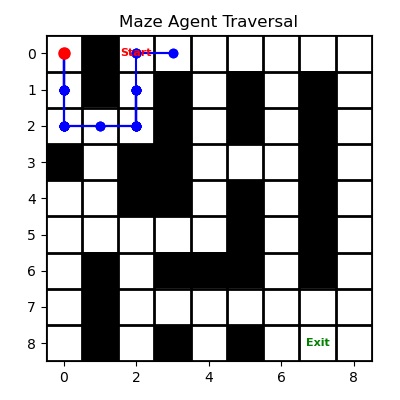

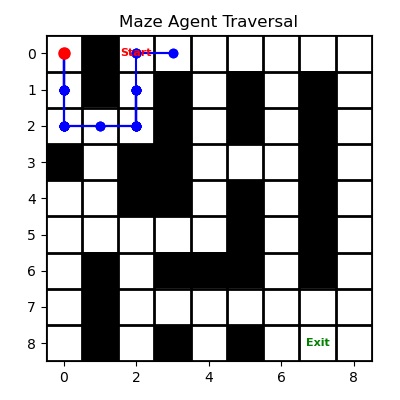

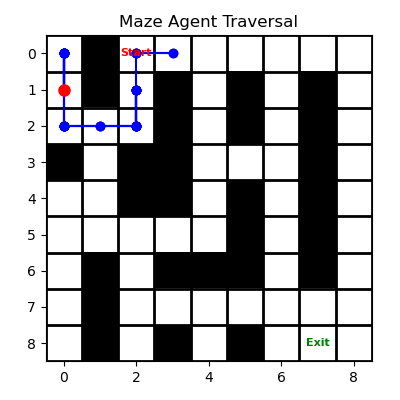

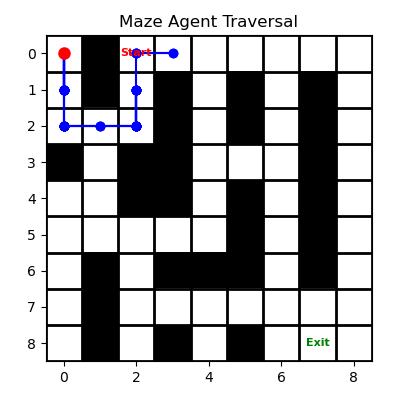

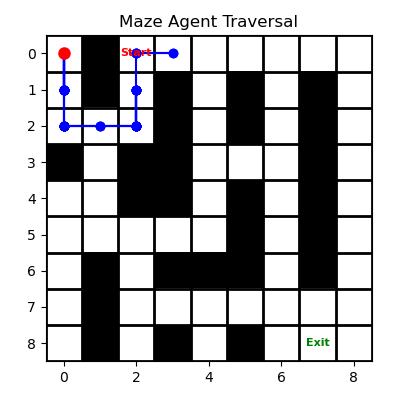

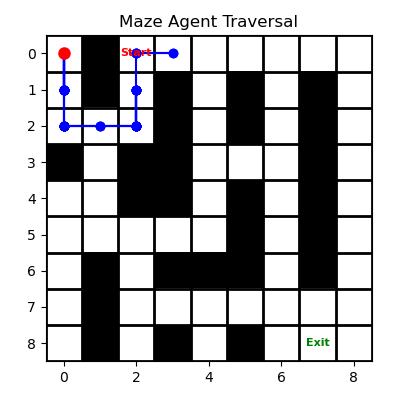

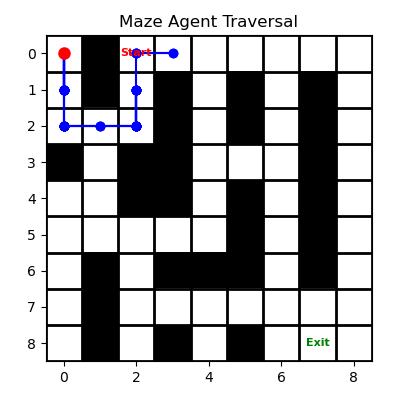

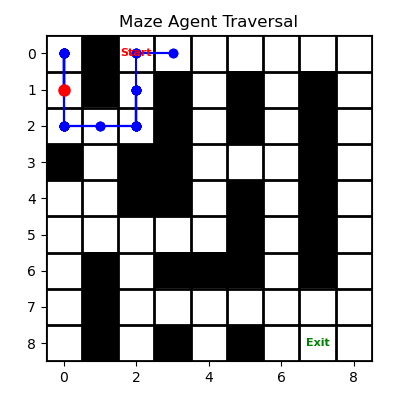

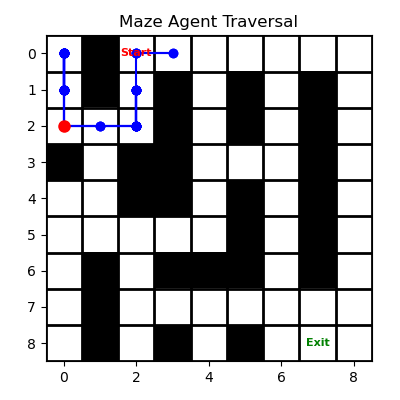

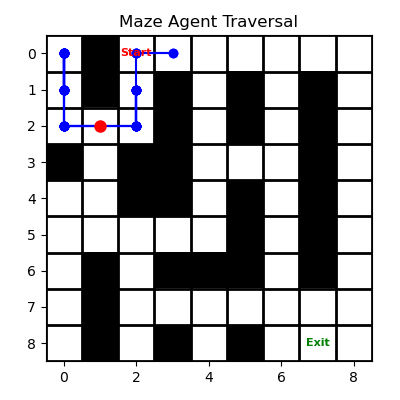

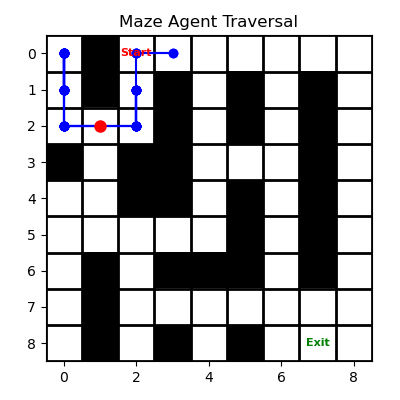

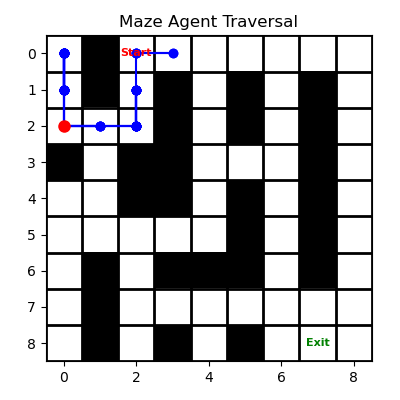

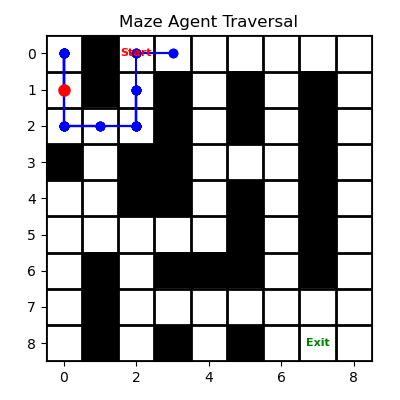

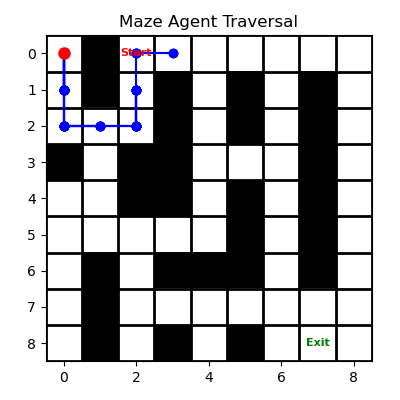

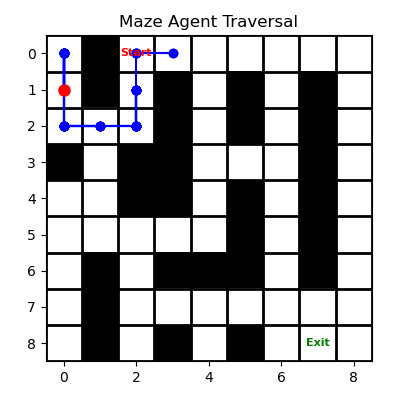

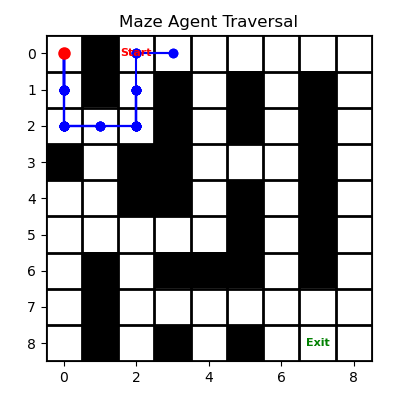

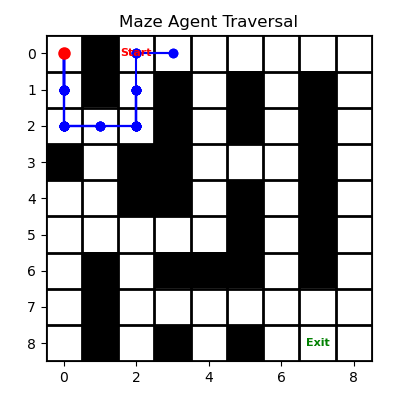

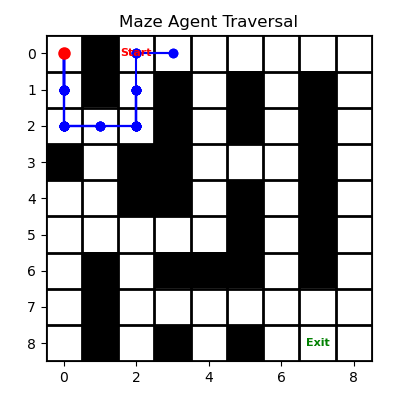

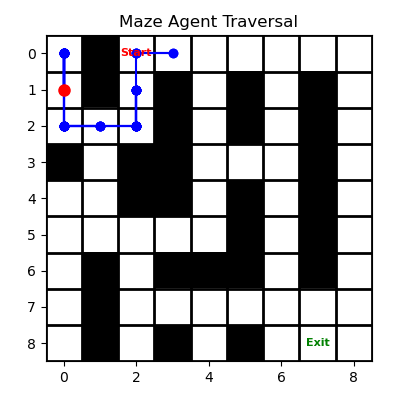

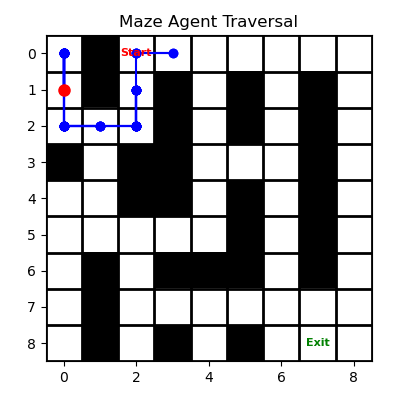

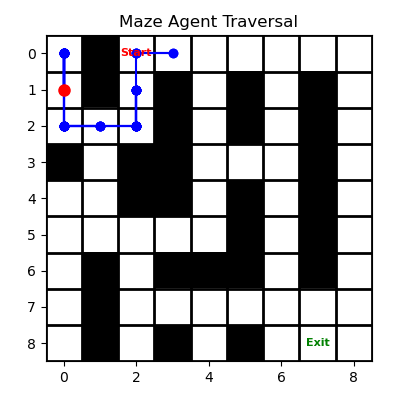

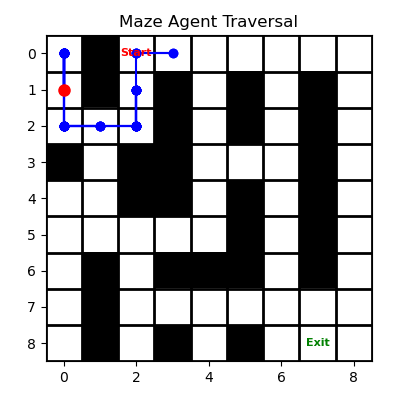

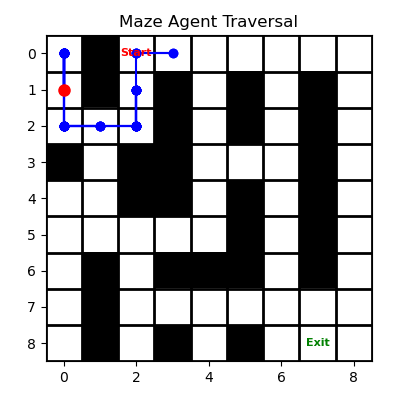

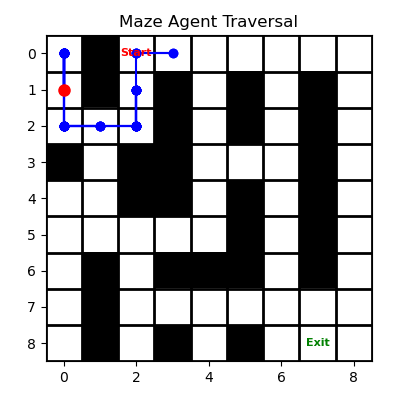

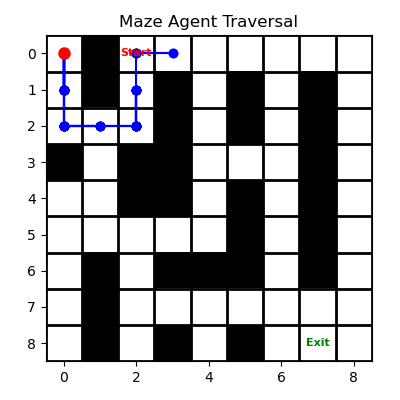

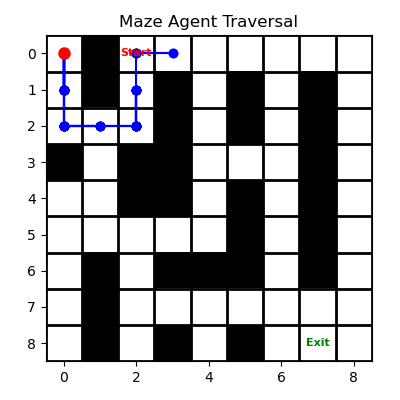

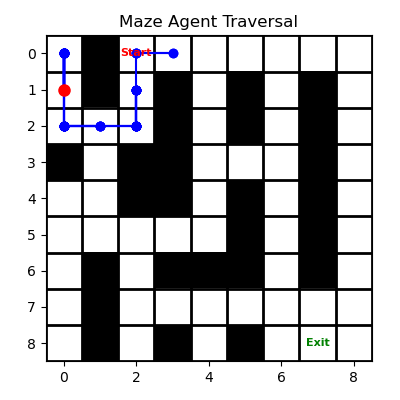

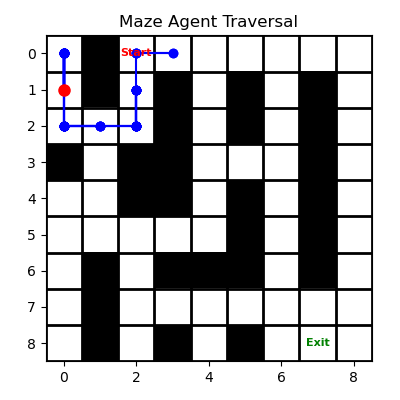

Random Baseline gameplay finished in 100 steps.


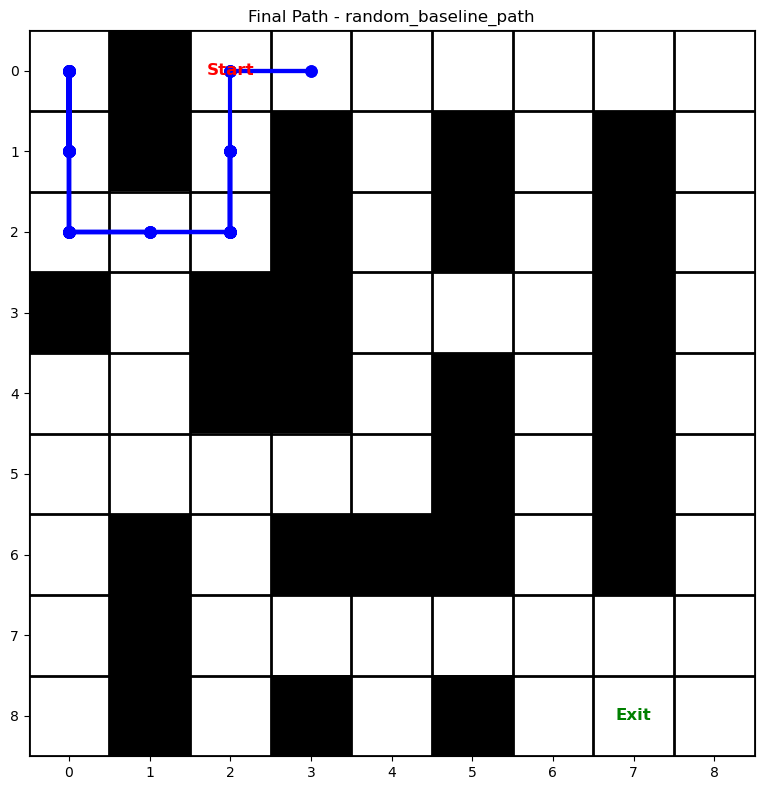

In [7]:
# --- Step 5: Baseline Heuristic (Random Policy) ---
visualize_gameplay(None, env, "Random Baseline", max_steps=100)
env.render_final("random_baseline_path.png")



Training Q-Learning Agent...
Q-Learning training time: 6.06 seconds


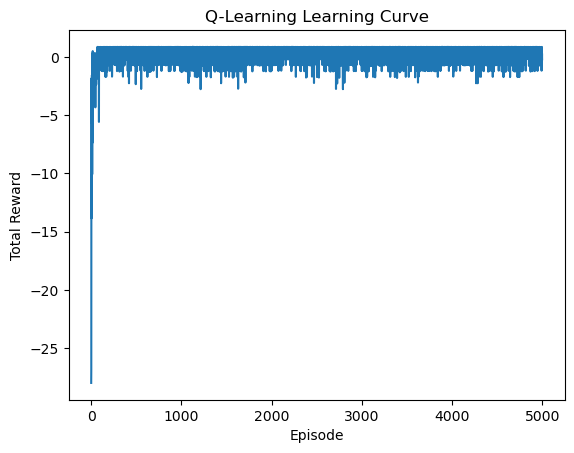


--- Visualizing Q-Learning ---


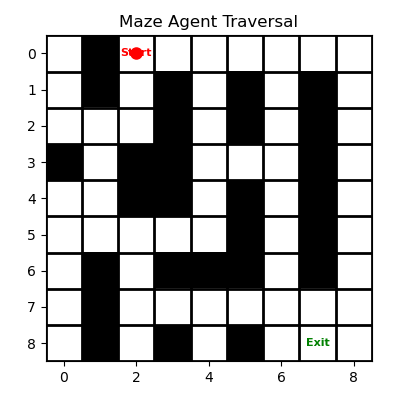

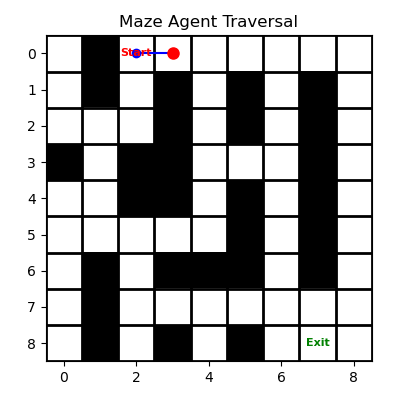

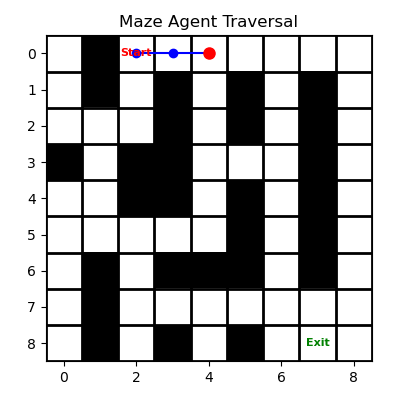

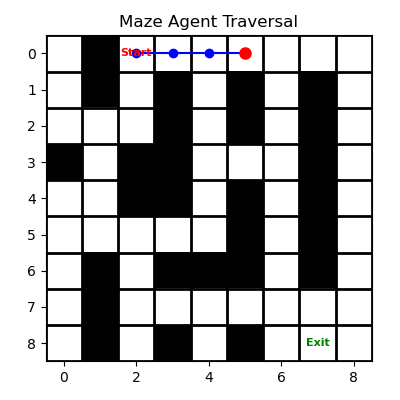

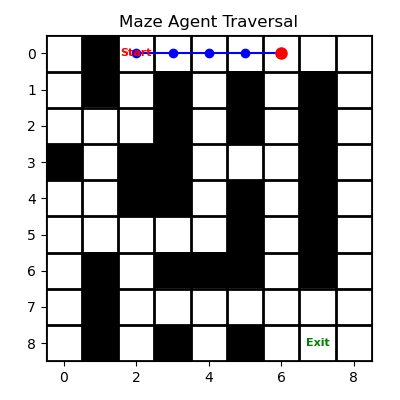

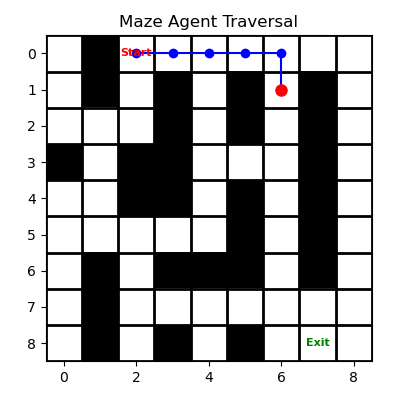

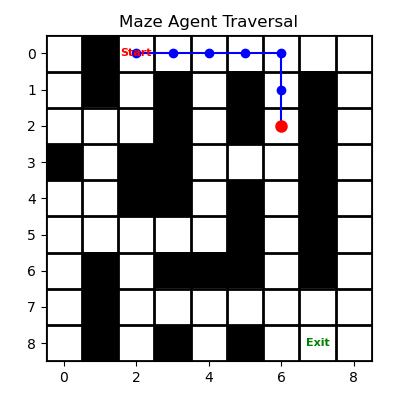

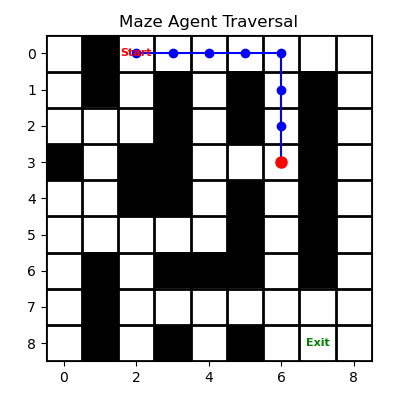

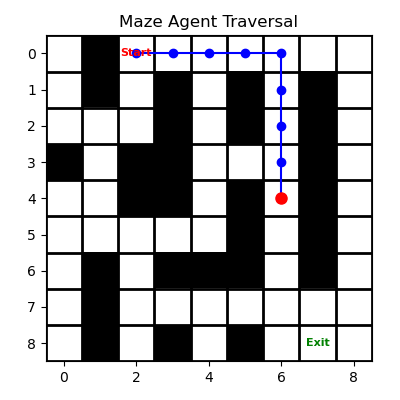

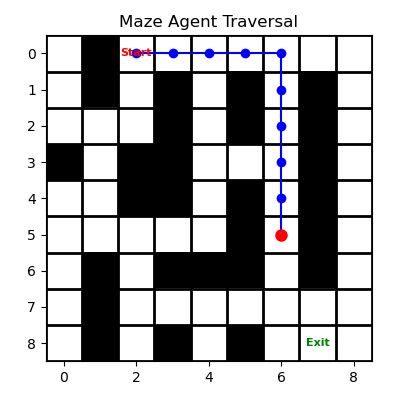

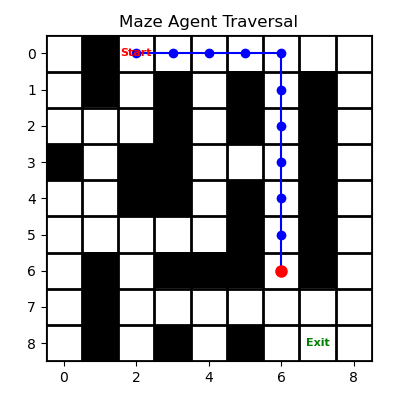

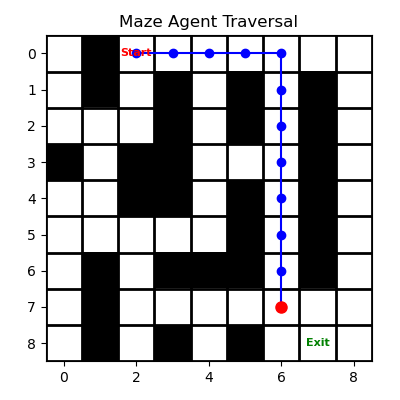

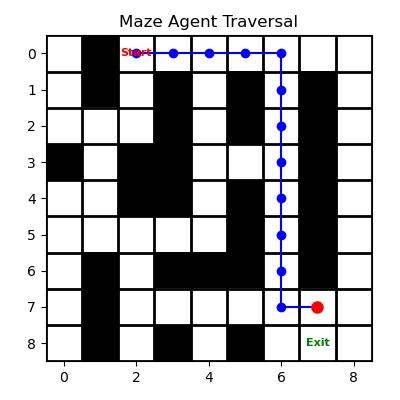

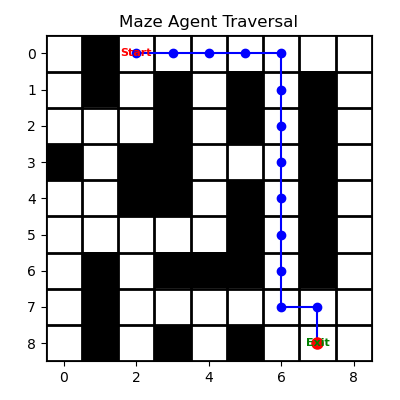

Q-Learning gameplay finished in 13 steps.


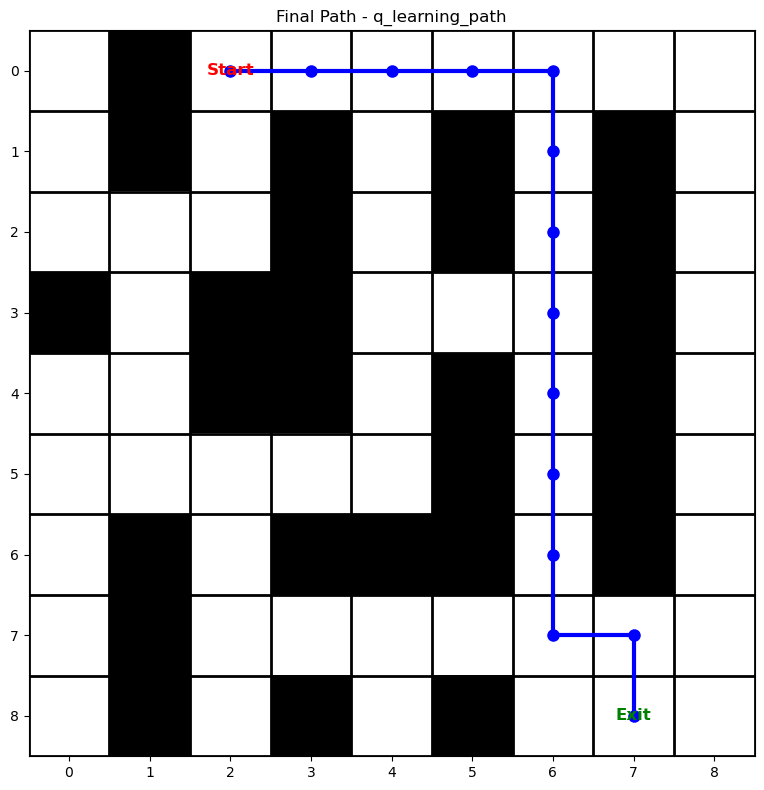

In [19]:
# --- Step 6: Q-Learning Implementation and Visualization ---
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((env.n_rows, env.n_cols, env.action_space.n))

    def choose_action(self, state):
        r, c = state.astype(int)
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[r, c])

    def learn(self, state, action, reward, next_state):
        r, c = state.astype(int)
        nr, nc = next_state.astype(int)
        predict = self.q_table[r, c, action]
        target = reward + self.gamma * np.max(self.q_table[nr, nc])
        self.q_table[r, c, action] += self.alpha * (target - predict)

print("\nTraining Q-Learning Agent...")
q_agent = QLearningAgent(env)
episodes = 5000
q_rewards = []
start_time = time.time()
for ep in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = q_agent.choose_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        q_agent.learn(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    q_rewards.append(total_reward)
end_time = time.time()
print(f"Q-Learning training time: {end_time - start_time:.2f} seconds")

# Visualize Q-Learning
plt.figure()
plt.plot(q_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning Learning Curve')
plt.savefig('q_learning_learning_curve.png')
plt.show()

# Visualize Q-Learning gameplay
visualize_gameplay(q_agent, env, "Q-Learning")
env.render_final("q_learning_path.png")


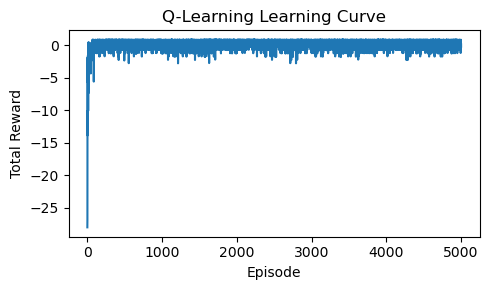


--- Visualizing Q-Learning ---


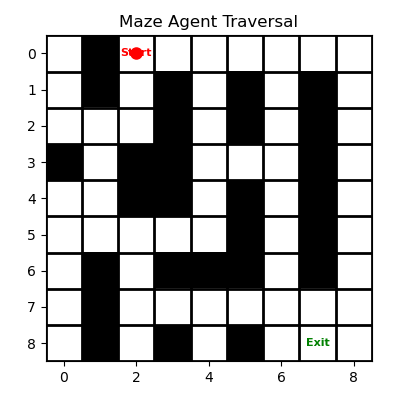

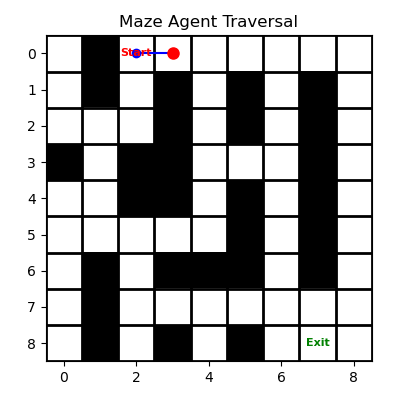

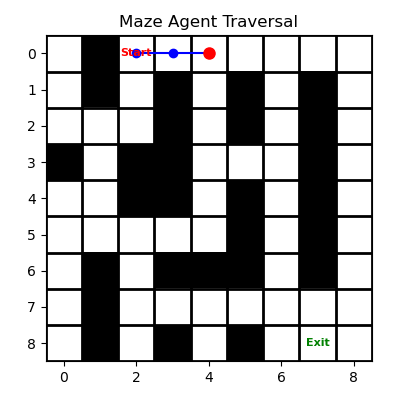

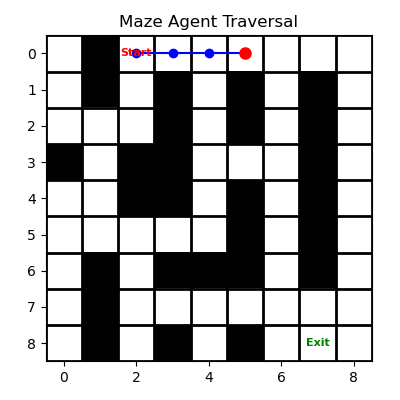

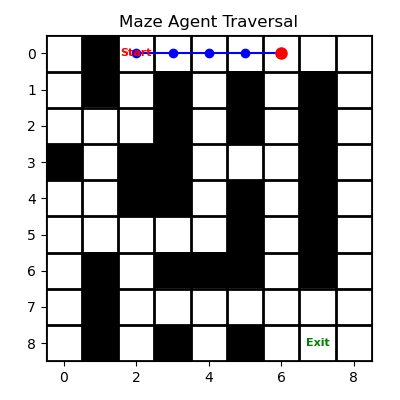

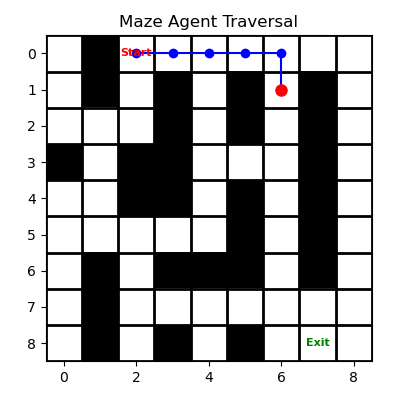

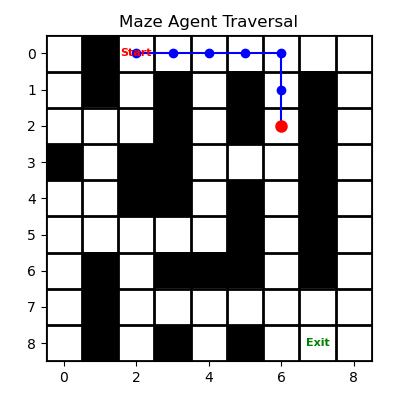

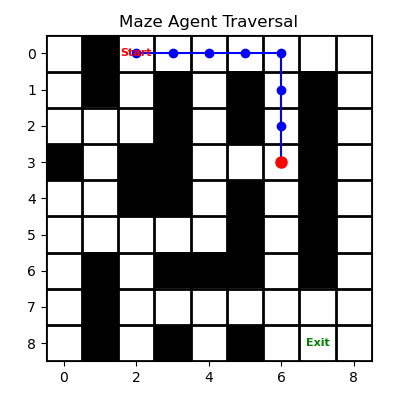

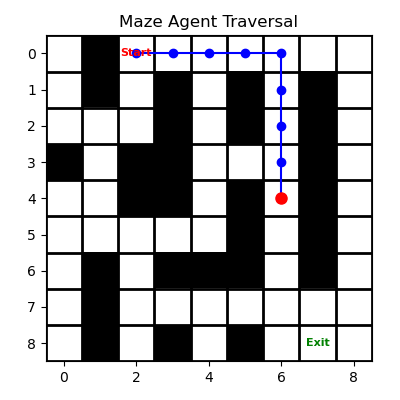

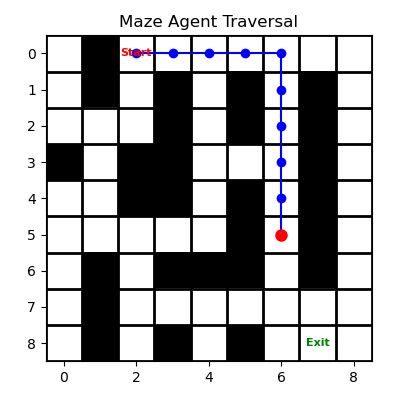

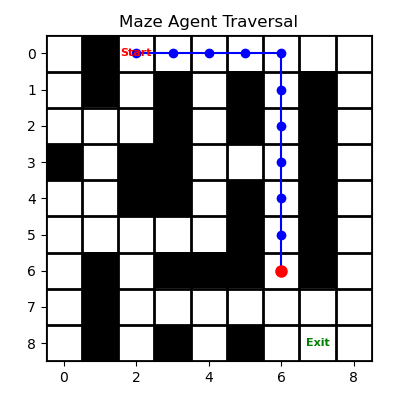

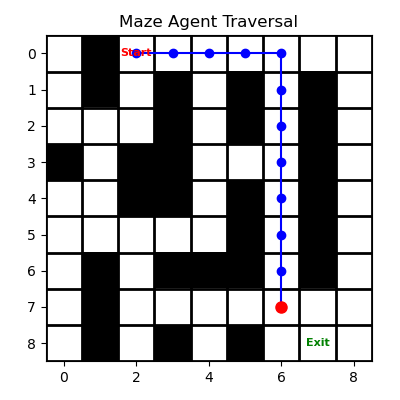

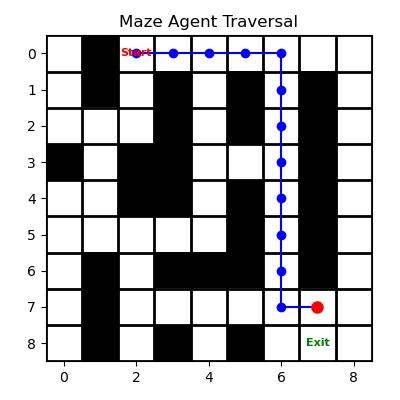

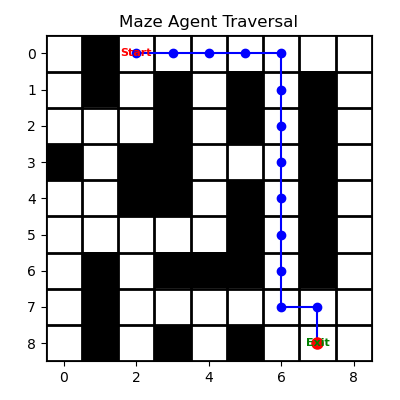

Q-Learning gameplay finished in 13 steps.


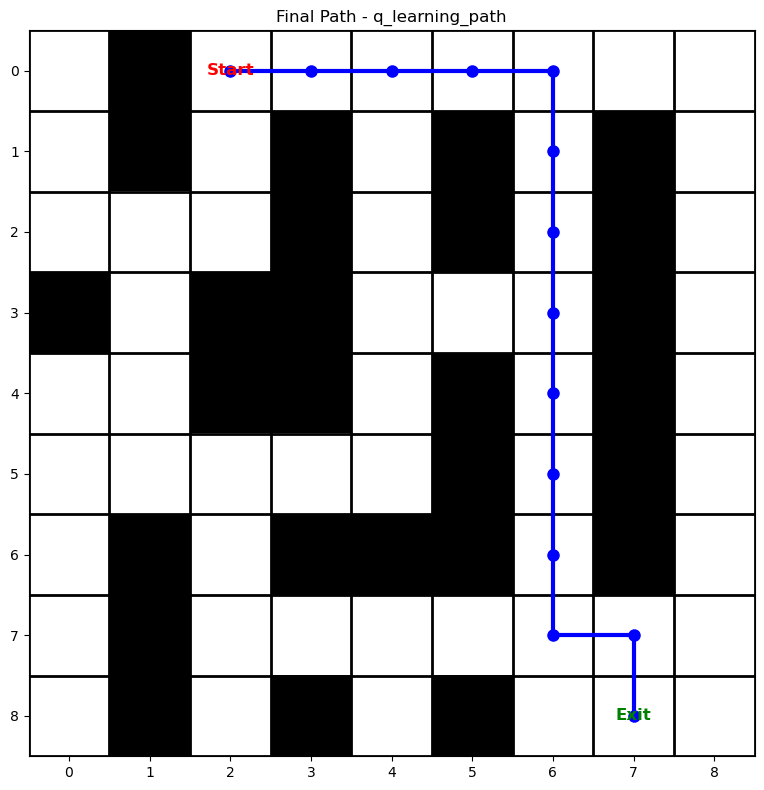

In [22]:
# Visualize Q-Learning
plt.figure(figsize=(5, 3))  # Width=5, Height=3 (smaller graph)
plt.plot(q_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning Learning Curve')
plt.tight_layout()  # Adjusts spacing to prevent overlap
plt.savefig('q_learning_learning_curve.png', dpi=100)  # dpi controls resolution
plt.show()

# Visualize Q-Learning gameplay
visualize_gameplay(q_agent, env, "Q-Learning")
env.render_final("q_learning_path.png")



Training PPO Agent...


C:\Users\nehak\anaconda3\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


PPO training time: 529.59 seconds

--- Visualizing PPO ---


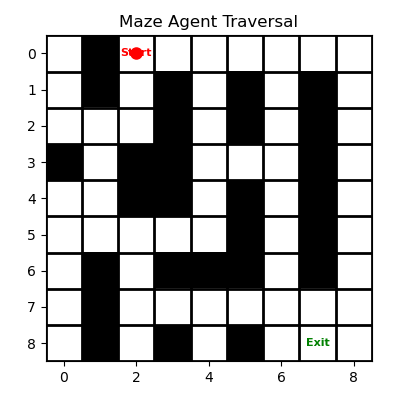

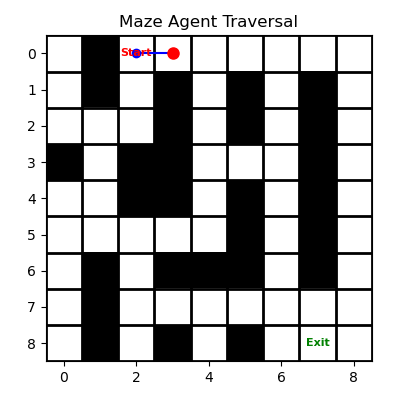

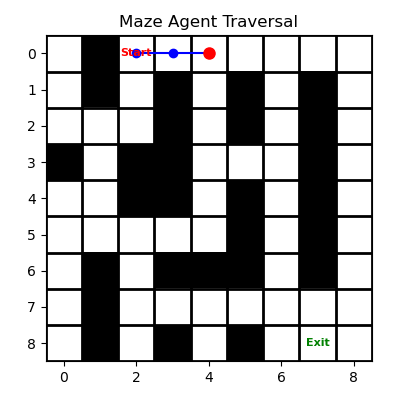

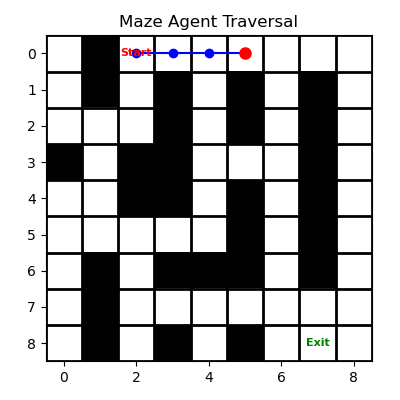

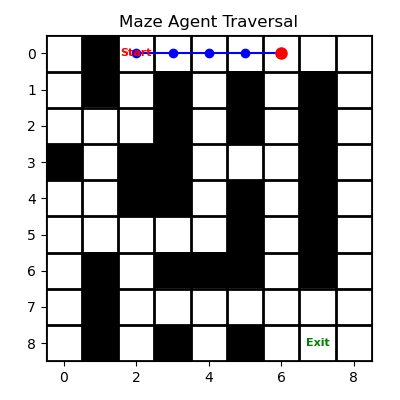

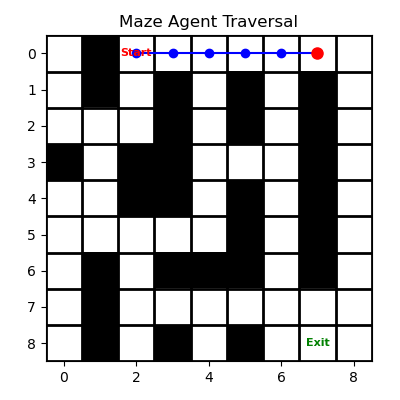

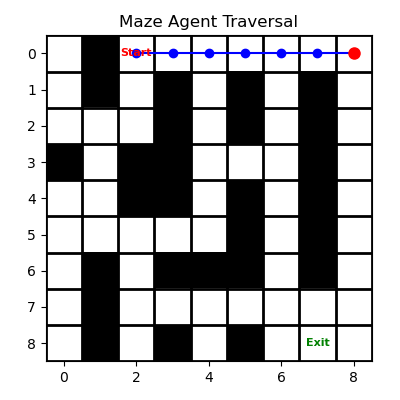

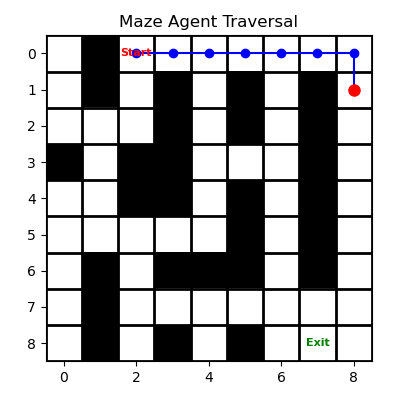

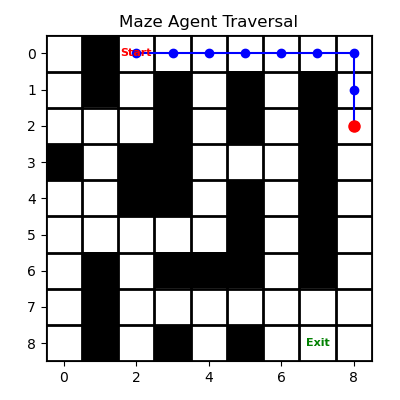

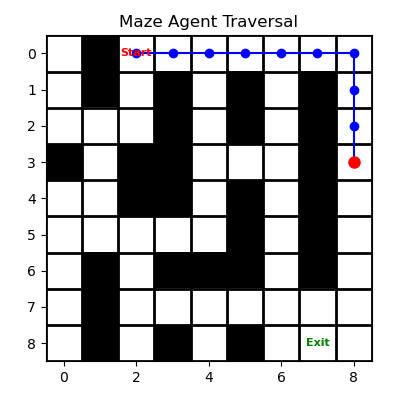

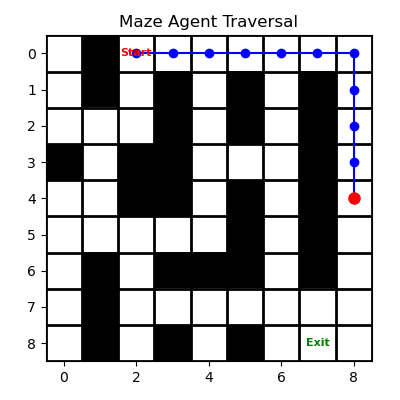

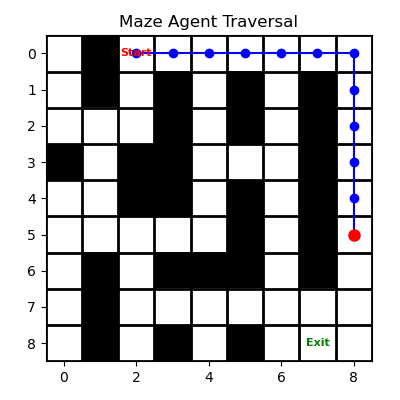

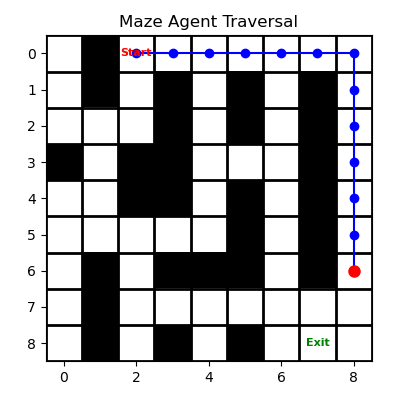

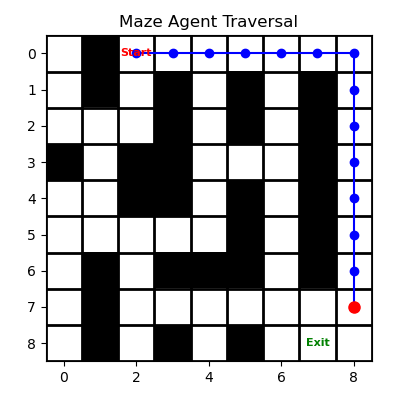

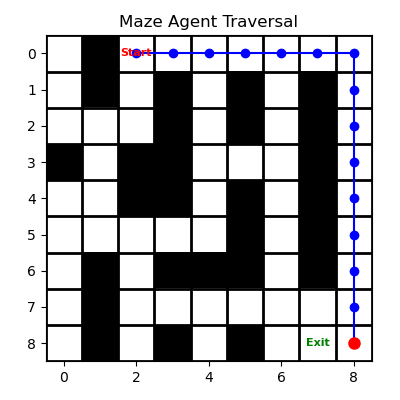

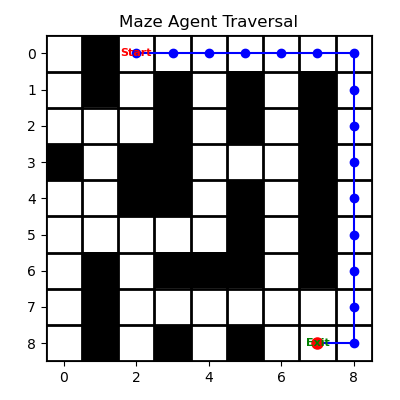

PPO gameplay finished in 15 steps.


AttributeError: 'Monitor' object has no attribute 'render_final'

In [15]:
# --- Step 7: PPO Training and Visualization ---
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

print("\nTraining PPO Agent...")
sb3_env = DummyVecEnv([lambda: Monitor(MazeEnv(maze_layout, start_cell, exit_cell))])
ppo_model = PPO("MlpPolicy", sb3_env, verbose=0, seed=SEED)
start_time = time.time()
ppo_model.learn(total_timesteps=50000)
end_time = time.time()
print(f"PPO training time: {end_time - start_time:.2f} seconds")

# Visualize PPO run
visualize_gameplay(ppo_model, sb3_env.envs[0], "PPO")
sb3_env.envs[0].render_final("ppo_path.png")


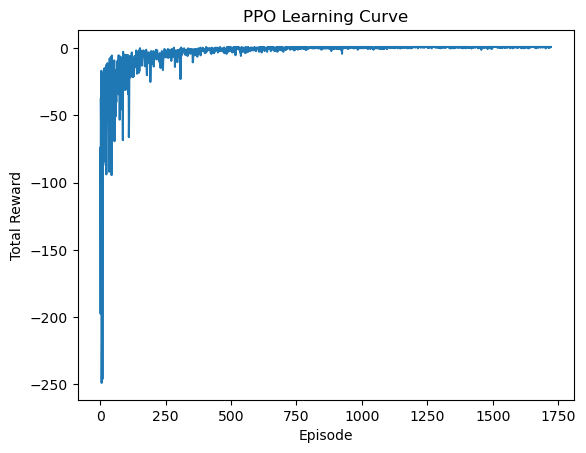

In [17]:
# Visualize PPO Learning Curve
# Note: sb3_env is the DummyVecEnv wrapped with Monitor
ppo_rewards = sb3_env.envs[0].get_episode_rewards()

plt.figure()
plt.plot(ppo_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO Learning Curve')
plt.savefig('ppo_learning_curve.png')
plt.show()


Generating Q-Value Heatmap for Q-Learning...


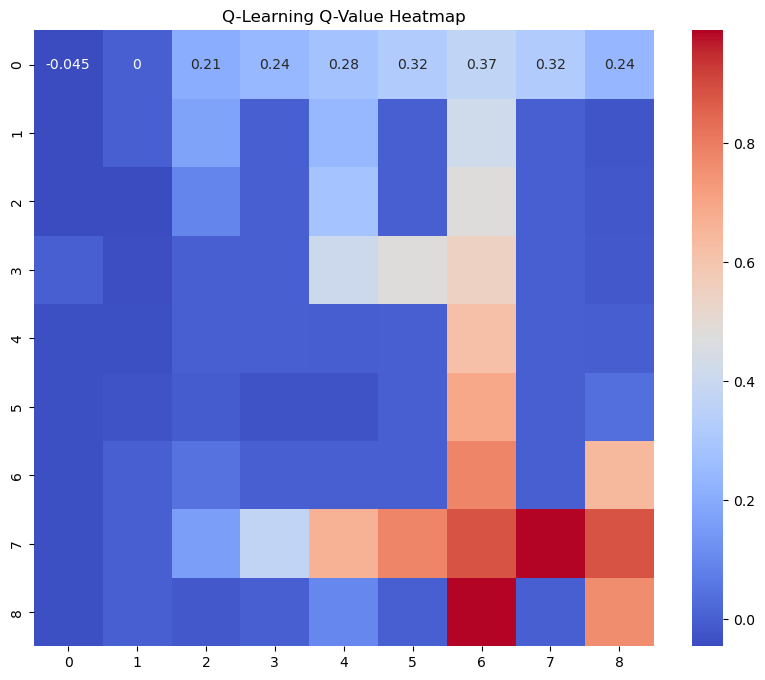

All code execution complete.


In [20]:
# --- Step 9: Reward Shaping Analysis (Heatmap of Q-values) ---
print("\nGenerating Q-Value Heatmap for Q-Learning...")
plt.figure(figsize=(10, 8))
sns.heatmap(np.max(q_agent.q_table, axis=2), annot=True, cmap="coolwarm")
plt.title("Q-Learning Q-Value Heatmap")
plt.savefig('q_value_heatmap.png')
plt.show()

print("All code execution complete.")


Generating PPO Policy Heatmap...


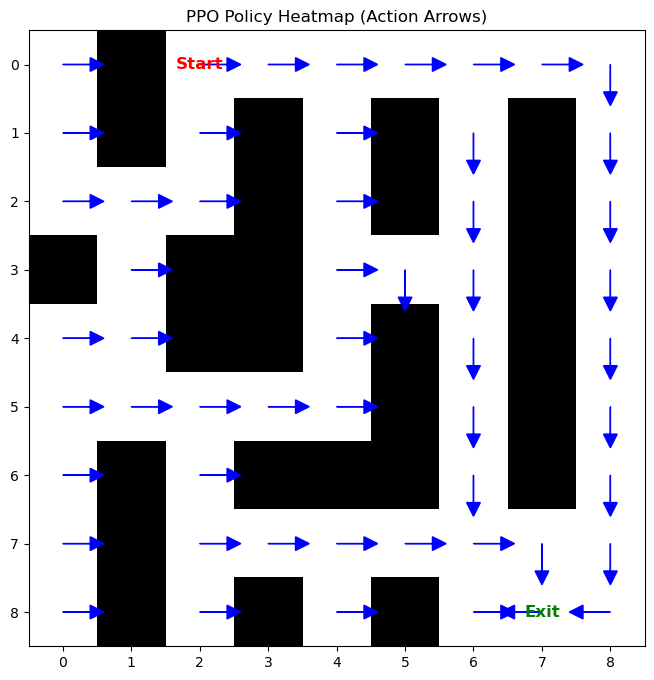

In [21]:
# --- PPO Policy Heatmap ---
print("\nGenerating PPO Policy Heatmap...")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Define the grid
n_rows, n_cols = env.n_rows, env.n_cols
x_coords, y_coords = np.meshgrid(np.arange(n_cols), np.arange(n_rows))
ax.imshow(env.maze, cmap=plt.cm.binary)

# Iterate through each grid cell to get the optimal action
for r in range(n_rows):
    for c in range(n_cols):
        # Skip walls
        if env.maze[r, c] == 1:
            continue
        
        # Get the optimal action from the PPO model for this state
        obs = np.array([r, c], dtype=np.float32)
        action, _ = ppo_model.predict(obs, deterministic=True)
        
        # Map action to a direction and draw an arrow
        if action == 0:  # Up
            ax.arrow(c, r, 0, -0.4, head_width=0.2, head_length=0.2, fc='b', ec='b')
        elif action == 1:  # Down
            ax.arrow(c, r, 0, 0.4, head_width=0.2, head_length=0.2, fc='b', ec='b')
        elif action == 2:  # Left
            ax.arrow(c, r, -0.4, 0, head_width=0.2, head_length=0.2, fc='b', ec='b')
        elif action == 3:  # Right
            ax.arrow(c, r, 0.4, 0, head_width=0.2, head_length=0.2, fc='b', ec='b')

# Label Start and Exit
ax.text(env.start_cell[1], env.start_cell[0], 'Start', color='red', ha='center', va='center', fontsize=12, fontweight='bold')
ax.text(env.exit_cell[1], env.exit_cell[0], 'Exit', color='green', ha='center', va='center', fontsize=12, fontweight='bold')

plt.title("PPO Policy Heatmap (Action Arrows)")
plt.xticks(np.arange(n_cols))
plt.yticks(np.arange(n_rows))
plt.grid(which="minor", color="black", linestyle='-', linewidth=2)
plt.savefig('ppo_policy_heatmap.png')
plt.show()